# Gendered perspectives on character.


In [38]:
import csv, math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from adjustText import adjust_text
%matplotlib inline

In [6]:
data = pd.read_csv('chartable.tsv', sep = '\t')

In [19]:
lexicon = pd.read_csv('lexicon.tsv', sep = '\t')
vocab = set(lexicon.word[0:2000])

In [32]:
def dunnings(vectora, vectorb):
    ''' Calculates Dunning's log-likelihood (a signed version)
    '''
    assert len(vectora) == len(vectorb)
    veclen = len(vectora)
    totala = np.sum(vectora)
    totalb = np.sum(vectorb)
    totalboth = totala + totalb

    dunningvector = np.zeros(veclen)

    for i in range(veclen):
        if vectora[i] == 0 or vectorb[i] == 0:
            continue
            # Cause you know you're going to get div0 errors.

        try:
            probI = (vectora[i] + vectorb[i]) / totalboth
            probnotI = 1 - probI
            expectedIA = totala * probI
            expectedIB = totalb * probI
            expectedNotIA = totala * probnotI
            expectedNotIB = totalb * probnotI
            expected_table = np.array([[expectedIA, expectedNotIA],
                [expectedIB, expectedNotIB]])
            actual_table = np.array([[vectora[i], (totala - vectora[i])],
                [vectorb[i], (totalb - vectorb[i])]])
            G = np.sum(actual_table * np.log(actual_table / expected_table))

            # take an additional log to make it visualizable
            G = math.log(G)
            # We're going to use a signed version of Dunnings, so features where
            # B is higher than expected will be negative.

            if expectedIB > vectorb[i]:
                G = -G

            dunningvector[i] = G

        except:
            pass
            # There are a million ways to get a div-by-zero or log-zero error
            # in that calculation. I could check them all, or just do this.
            # The vector was initialized with zeroes, which are the default
            # value I want for failed calculations anyhow.

    return dunningvector

In [44]:
def sumwords(df):
    grouped = df.groupby('word')
    wordsums = grouped.aggregate(np.sum)
    return wordsums.wordct

def dunningsforauthgender(data, authgender):
    perspectiveonmen = data[(data.authgender == authgender) & (data.chargender == 'm')]
    perspectiveonwomen = data[(data.authgender == authgender) & (data.chargender == 'f')]
    mascwords = sumwords(perspectiveonmen).rename('m')
    femwords = sumwords(perspectiveonwomen).rename('f')
    comparison = pd.concat([femwords, mascwords], axis = 1)
    comparison.fillna(0, inplace = True)
    gvals = dunnings(comparison.m, comparison.f)
    comparison = comparison.assign(g = gvals)
    comparison.sort_values(by = 'g', inplace = True)
    
    return comparison

f_perspective = dunningsforauthgender(data, 'f')
m_perspective = dunningsforauthgender(data, 'm')

gforf = f_perspective.g.rename('f')
gform = m_perspective.g.rename('m')
twoperspectives = pd.concat([gforf, gform], axis = 1)
twoperspectives.fillna(0, inplace = True)
twoperspectives['word'] = twoperspectives.index
twoperspectives.head()

,f,m,word
'd,5.192914,5.713372,'d
'll,-2.217192,-2.952117,'ll
'm,-1.487285,-1.569018,'m
're,-0.111303,-2.603079,'re
's,-6.029262,2.402428,'s


In [53]:
def plot_gender_means(words, frametoplot, adjust=True, title=False, label_outliers=True, normalize_axes=False, save=False):
    df = frametoplot.loc[(frametoplot.word.isin(words)),:]
    ax0 = df.plot('f', 'm', kind='scatter', s=50, figsize=(15,15))
    ax0.plot(0, 0, 'r+', ms=15, mew=2, label='(0,0) Gender Neutral')
    
    texts = []
    for x, y, s in zip(df['f'], df['m'], df['word']):
        if label_outliers:
            if (((x < - 4.7) & (y > 4.7)) |((x > 4.7) & (y < -4.7))):
                texts.append(plt.text(x, y, s, size = 11))
            if (((x < -8.5) & (y < -8.5)) |((x > 9) & (y  > 9))):
                texts.append(plt.text(x, y, s, size=11))

    if adjust:
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
        
    plt.legend(loc='best')
    plt.xlabel('m     <--     Diff for women writers 1800-2000    -->     f', fontsize=16, )
    plt.ylabel('m     <--     Diff for male writers 1800-2000     -->     f', fontsize=16)
    if title:
        plt.title(title)
    if normalize_axes:
        ylim = ax0.get_ylim()
        xlim = ax0.get_xlim()
        new_low = min(xlim[0], ylim[0])
        new_hi = max(xlim[1], ylim[1])
        plt.ylim(new_low, new_hi)
        plt.xlim(new_low, new_hi)

    if save:
        if title:
            plt.savefig('./{}.png'.format(title))
        else:
            plt.savefig('./genderDiffMeans.png')
    plt.show()

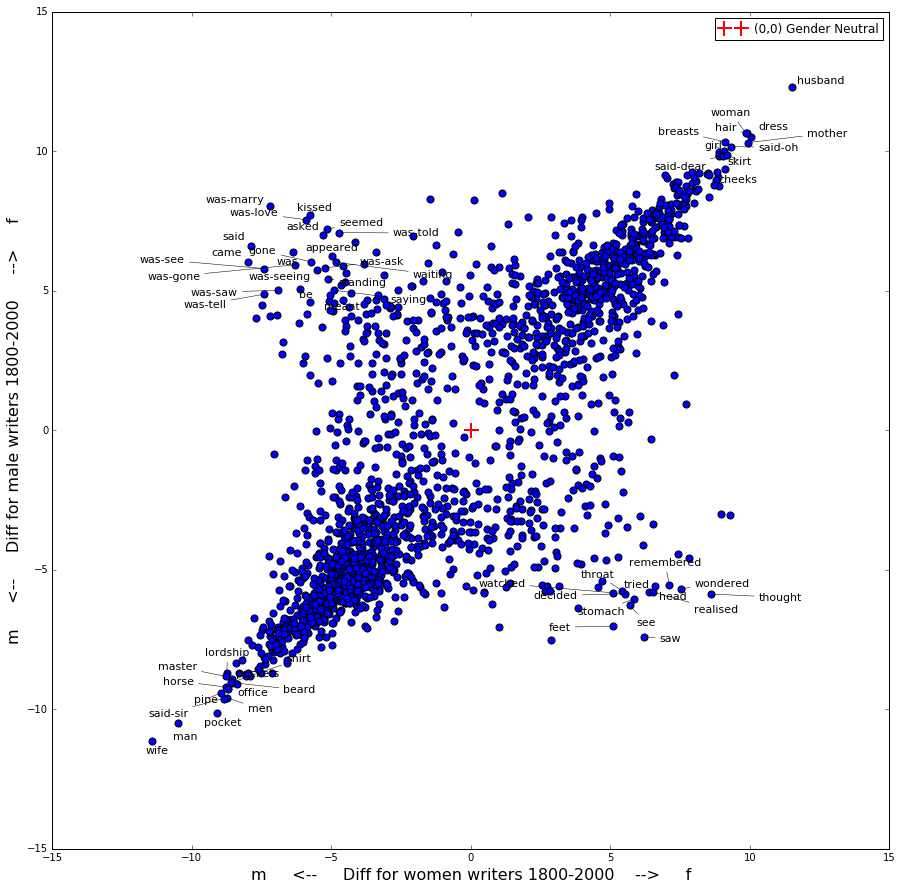

In [54]:
plot_gender_means(vocab, twoperspectives)